In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.metrics import (
    accuracy_score, classification_report,
    confusion_matrix, balanced_accuracy_score, roc_curve
)
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from xgboost import XGBClassifier

# --- Load Datasets ---
df = pd.read_csv("train_features.csv")
val_df = pd.read_csv("val_features.csv")
test_df = pd.read_csv("test_features.csv")

core_features = df.drop(columns=["label", "label_name"], errors="ignore").columns.tolist()

# --- Extract Features and Labels ---
X_train = df[core_features]
y_train = df["label"]
X_val = val_df[core_features]
y_val = val_df["label"]
X_test = test_df[core_features]
y_test = test_df["label"]

# --- Manual Grid Search using Validation Set ---
param_grid = {
    'max_depth': [3, 5, 7, 9, 11, 12, 13],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200]
}

best_score = 0
best_params = {}

# Class ratio for scale_pos_weight (Impaired : No Impairment)
num_classes = len(np.unique(y_train))

print("🔍 Hyperparameter tuning on validation set:")
for max_depth, lr, n_est in product(param_grid['max_depth'],
                                    param_grid['learning_rate'],
                                    param_grid['n_estimators']):
    model = XGBClassifier(
        objective='multi:softprob',
        use_label_encoder=False,
        eval_metric='logloss',
        scale_pos_weight=scale_pos_weight,
        max_depth=max_depth,
        learning_rate=lr,
        n_estimators=n_est,
        random_state=42,
        verbosity=0
    )
    model.fit(X_train, y_train)
    val_pred = model.predict(X_val)
    val_score = balanced_accuracy_score(y_val, val_pred)
    print(f"max_depth={max_depth}, lr={lr}, n_estimators={n_est} → Balanced Acc: {val_score:.4f}")
    if val_score > best_score:
        best_score = val_score
        best_params = {
            'max_depth': max_depth,
            'learning_rate': lr,
            'n_estimators': n_est
        }

print("\n✅ Best Params from validation set:")
print(best_params)
print(f"Best Validation Balanced Accuracy: {best_score:.4f}")

# --- Final Model with Early Stopping ---
clf = XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    num_class=num_classes,
    random_state=42,
    **best_params
)

clf.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

# --- Evaluation Utility ---
label_map_binary = {0: "No Impairment", 1: "Impaired"}

def evaluate_multiclass(model, X, y, dataset_name="Set"):
    y_pred = model.predict(X)
    print(f"\n🧪 {dataset_name} Performance (Multiclass)")
    print("Accuracy:", accuracy_score(y, y_pred))
    print("Balanced Accuracy:", balanced_accuracy_score(y, y_pred))
    print(classification_report(y, y_pred, digits=4))

    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix ({dataset_name})")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()


def find_best_threshold(y_true, y_probs):
    fpr, tpr, thresholds = roc_curve(y_true, y_probs)
    j_scores = tpr - fpr
    best_idx = np.argmax(j_scores)
    return thresholds[best_idx]

# --- Evaluate Final Model ---
best_thresh = find_best_threshold(y_test, clf.predict_proba(X_test)[:, 1])
print(f"Optimal threshold: {best_thresh:.4f}")
evaluate_multiclass(clf, X_test, y_test, "Test Set")


🔍 Hyperparameter tuning on validation set:
max_depth=3, lr=0.01, n_estimators=100 → Balanced Acc: 0.7441
max_depth=3, lr=0.01, n_estimators=200 → Balanced Acc: 0.7539
max_depth=3, lr=0.1, n_estimators=100 → Balanced Acc: 0.8372
max_depth=3, lr=0.1, n_estimators=200 → Balanced Acc: 0.8535
max_depth=5, lr=0.01, n_estimators=100 → Balanced Acc: 0.7734
max_depth=5, lr=0.01, n_estimators=200 → Balanced Acc: 0.7871
max_depth=5, lr=0.1, n_estimators=100 → Balanced Acc: 0.8678
max_depth=5, lr=0.1, n_estimators=200 → Balanced Acc: 0.8880
max_depth=7, lr=0.01, n_estimators=100 → Balanced Acc: 0.8008
max_depth=7, lr=0.01, n_estimators=200 → Balanced Acc: 0.8151
max_depth=7, lr=0.1, n_estimators=100 → Balanced Acc: 0.8900
max_depth=7, lr=0.1, n_estimators=200 → Balanced Acc: 0.9023
max_depth=9, lr=0.01, n_estimators=100 → Balanced Acc: 0.8242
max_depth=9, lr=0.01, n_estimators=200 → Balanced Acc: 0.8418
max_depth=9, lr=0.1, n_estimators=100 → Balanced Acc: 0.8919
max_depth=9, lr=0.1, n_estimators=

TypeError: XGBClassifier.fit() got an unexpected keyword argument 'early_stopping_rounds'

In [6]:

# --- Final Model with Early Stopping ---
clf = XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    **best_params
)

clf.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

# --- Evaluation Utility ---
label_map_binary = {0: "No Impairment", 1: "Impaired"}

def evaluate_binary(X, y, dataset_name="Set", threshold=0.5):
    probs = clf.predict_proba(X)[:, 1]
    y_pred = (probs >= threshold).astype(int)

    print(f"\n🧪 {dataset_name} Performance (Binary, Threshold = {threshold})")
    print("Accuracy:", accuracy_score(y, y_pred))
    print("Balanced Accuracy:", balanced_accuracy_score(y, y_pred))
    print(classification_report(y, y_pred, target_names=label_map_binary.values(), digits=4))

    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=label_map_binary.values(),
                yticklabels=label_map_binary.values(),
                annot_kws={"size": 14})
    plt.title(f"Confusion Matrix ({dataset_name})")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

def find_best_threshold(y_true, y_probs):
    fpr, tpr, thresholds = roc_curve(y_true, y_probs)
    j_scores = tpr - fpr
    best_idx = np.argmax(j_scores)
    return thresholds[best_idx]

# --- Evaluate Final Model ---
best_thresh = find_best_threshold(y_test, clf.predict_proba(X_test)[:, 1])
print(f"Optimal threshold: {best_thresh:.4f}")
evaluate_binary(X_test, y_test, "Test Set (Optimized Threshold)", threshold=best_thresh)


/home/alof/anaconda3/envs/brainml/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [21:23:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoostError: [21:23:06] /workspace/src/metric/elementwise_metric.cu:361: Check failed: preds.Size() == info.labels.Size() (6144 vs. 1536) : label and prediction size not match, hint: use merror or mlogloss for multi-class classification
Stack trace:
  [bt] (0) /home/alof/anaconda3/envs/brainml/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x2a6acc) [0x7a40db8a6acc]
  [bt] (1) /home/alof/anaconda3/envs/brainml/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0xd86ee3) [0x7a40dc386ee3]
  [bt] (2) /home/alof/anaconda3/envs/brainml/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x6b1ea6) [0x7a40dbcb1ea6]
  [bt] (3) /home/alof/anaconda3/envs/brainml/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x68ad80) [0x7a40dbc8ad80]
  [bt] (4) /home/alof/anaconda3/envs/brainml/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(XGBoosterEvalOneIter+0x1d6) [0x7a40db7bf2f6]
  [bt] (5) /home/alof/anaconda3/envs/brainml/lib/python3.10/lib-dynload/../../libffi.so.8(+0x6d8a) [0x7a4177386d8a]
  [bt] (6) /home/alof/anaconda3/envs/brainml/lib/python3.10/lib-dynload/../../libffi.so.8(+0x61cd) [0x7a41773861cd]
  [bt] (7) /home/alof/anaconda3/envs/brainml/lib/python3.10/lib-dynload/../../libffi.so.8(ffi_call+0xcd) [0x7a417738691d]
  [bt] (8) /home/alof/anaconda3/envs/brainml/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0x931f) [0x7a417897831f]



# After Hypertuning
Best values found were:
- `n_estimators`: 200
- `max_depth`: 15
- `lr`: 1

/home/alof/anaconda3/envs/brainml/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:25:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



🧪 Test Set Performance (Binary, Threshold = 0.45)
Accuracy: 0.8577013291634089
Balanced Accuracy: 0.8576853482003131
               precision    recall  f1-score   support

No Impairment     0.8438    0.8781    0.8606       640
     Impaired     0.8728    0.8372    0.8546       639

     accuracy                         0.8577      1279
    macro avg     0.8583    0.8577    0.8576      1279
 weighted avg     0.8583    0.8577    0.8576      1279



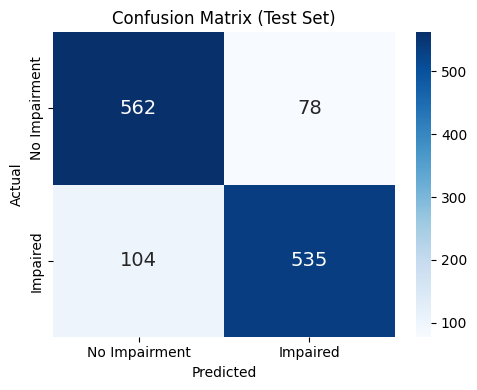

In [ ]:
# --- Train Final Model on Combined Data ---
clf = XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    **best_params
)
clf.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

# --- Evaluation Utility ---
label_map_binary = {0: "No Impairment", 1: "Impaired"}

def evaluate_binary(X, y, dataset_name="Set", threshold=0.5):
    probs = clf.predict_proba(X)[:, 1]
    y_pred = (probs >= threshold).astype(int)

    print(f"\n🧪 {dataset_name} Performance (Binary, Threshold = {threshold})")
    print("Accuracy:", accuracy_score(y, y_pred))
    print("Balanced Accuracy:", balanced_accuracy_score(y, y_pred))
    print(classification_report(y, y_pred, target_names=label_map_binary.values(), digits=4))

    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=label_map_binary.values(),
                yticklabels=label_map_binary.values(),
                annot_kws={"size": 14})
    plt.title(f"Confusion Matrix ({dataset_name})")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

# --- Evaluate Final Model ---
evaluate_binary(X_test_scaled, y_test, "Test Set", threshold=0.45)

🔍 Cross-validation search:
max_depth=7, lr=0.01, n_estimators=100 → Mean Balanced Acc: 0.8646
max_depth=7, lr=0.01, n_estimators=200 → Mean Balanced Acc: 0.8728
max_depth=7, lr=0.01, n_estimators=300 → Mean Balanced Acc: 0.8784
max_depth=7, lr=0.01, n_estimators=400 → Mean Balanced Acc: 0.8839
max_depth=7, lr=0.05, n_estimators=100 → Mean Balanced Acc: 0.8866
max_depth=7, lr=0.05, n_estimators=200 → Mean Balanced Acc: 0.8958
max_depth=7, lr=0.05, n_estimators=300 → Mean Balanced Acc: 0.8992
max_depth=7, lr=0.05, n_estimators=400 → Mean Balanced Acc: 0.9010
max_depth=7, lr=0.1, n_estimators=100 → Mean Balanced Acc: 0.8977
max_depth=7, lr=0.1, n_estimators=200 → Mean Balanced Acc: 0.9010
max_depth=7, lr=0.1, n_estimators=300 → Mean Balanced Acc: 0.9027
max_depth=7, lr=0.1, n_estimators=400 → Mean Balanced Acc: 0.9026
max_depth=7, lr=0.2, n_estimators=100 → Mean Balanced Acc: 0.8966
max_depth=7, lr=0.2, n_estimators=200 → Mean Balanced Acc: 0.9004
max_depth=7, lr=0.2, n_estimators=300 → M

/home/alof/anaconda3/envs/brainml/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [21:07:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Optimal threshold: 0.4490

🧪 Test Set Performance (Threshold = 0.4490)
Accuracy: 0.8764659890539483
Balanced Accuracy: 0.8764451291079812
               precision    recall  f1-score   support

No Impairment     0.8576    0.9031    0.8798       640
     Impaired     0.8975    0.8498    0.8730       639

     accuracy                         0.8765      1279
    macro avg     0.8775    0.8764    0.8764      1279
 weighted avg     0.8775    0.8765    0.8764      1279



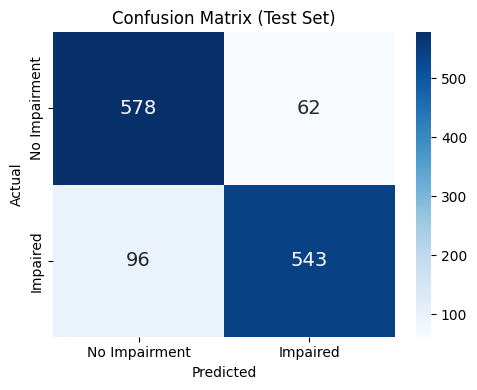

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import (
    accuracy_score, classification_report,
    confusion_matrix, balanced_accuracy_score, roc_curve
)
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from xgboost import XGBClassifier

# --- Load Datasets ---
df = pd.read_csv("train_features.csv")
test_df = pd.read_csv("test_features.csv")

# --- Re-label as binary: 0 = No Impairment, 1 = Any Impairment ---
df['label'] = df['label'].apply(lambda x: 0 if x == 0 else 1)
test_df['label'] = test_df['label'].apply(lambda x: 0 if x == 0 else 1)

# --- Extract Features ---
X = df.drop(columns=["label", "label_name"], errors="ignore")
y = df["label"]
X_test = test_df[X.columns]
y_test = test_df["label"]

# --- Scale Features ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

# --- Hyperparameter Grid ---
param_grid = {
    'max_depth': [7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300, 400]
}

best_score = 0
best_params = {}

# Class ratio for scale_pos_weight (Impaired : No Impairment)
scale_pos_weight = sum(y == 0) / sum(y == 1)

# --- Cross-Validation Search ---
print("🔍 Cross-validation search:")
for max_depth, lr, n_est in product(param_grid['max_depth'],
                                    param_grid['learning_rate'],
                                    param_grid['n_estimators']):
    model = XGBClassifier(
        objective='binary:logistic',
        use_label_encoder=False,
        eval_metric='logloss',
        scale_pos_weight=scale_pos_weight,
        max_depth=max_depth,
        learning_rate=lr,
        n_estimators=n_est,
        random_state=42,
        verbosity=0
    )
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_scaled, y, cv=skf, scoring='balanced_accuracy')
    mean_score = np.mean(scores)
    print(f"max_depth={max_depth}, lr={lr}, n_estimators={n_est} → Mean Balanced Acc: {mean_score:.4f}")
    
    if mean_score > best_score:
        best_score = mean_score
        best_params = {
            'max_depth': max_depth,
            'learning_rate': lr,
            'n_estimators': n_est
        }

print("\n✅ Best Params from CV:")
print(best_params)
print(f"Best CV Balanced Accuracy: {best_score:.4f}")

# --- Train Final Model ---
clf = XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    **best_params
)
clf.fit(X_scaled, y)

# --- Evaluation Utility ---
label_map_binary = {0: "No Impairment", 1: "Impaired"}

def evaluate_binary(X, y, dataset_name="Set", threshold=0.5):
    probs = clf.predict_proba(X)[:, 1]
    y_pred = (probs >= threshold).astype(int)

    print(f"\n🧪 {dataset_name} Performance (Threshold = {threshold:.4f})")
    print("Accuracy:", accuracy_score(y, y_pred))
    print("Balanced Accuracy:", balanced_accuracy_score(y, y_pred))
    print(classification_report(y, y_pred, target_names=label_map_binary.values(), digits=4))

    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=label_map_binary.values(),
                yticklabels=label_map_binary.values(),
                annot_kws={"size": 14})
    plt.title(f"Confusion Matrix ({dataset_name})")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

def find_best_threshold(y_true, y_probs):
    fpr, tpr, thresholds = roc_curve(y_true, y_probs)
    j_scores = tpr - fpr
    best_idx = np.argmax(j_scores)
    return thresholds[best_idx]

# --- Evaluate on Test Set ---
best_thresh = find_best_threshold(y_test, clf.predict_proba(X_test_scaled)[:, 1])
print(f"\nOptimal threshold: {best_thresh:.4f}")
evaluate_binary(X_test_scaled, y_test, "Test Set", threshold=best_thresh)
